# Example notebook for analysing event and cluster data from Krakow Test Beam
+ I give some example histograms with various cuts and stuff
+ Important was to establish the procedure for getting the corryvreckan data and looping over the trees

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1">Import libraries</a></span></li><li><span><a href="#Read-root-file-and-convert-to-python" data-toc-modified-id="Read-root-file-and-convert-to-python-2">Read root file and convert to python</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3">Analysis</a></span><ul class="toc-item"><li><span><a href="#Cluster-size-(also-column-width-/-row-width-of-clusters)" data-toc-modified-id="Cluster-size-(also-column-width-/-row-width-of-clusters)-3.1">Cluster size (also column width / row width of clusters)</a></span></li><li><span><a href="#Number-of-clusters" data-toc-modified-id="Number-of-clusters-3.2">Number of clusters</a></span></li><li><span><a href="#Correlation-plots" data-toc-modified-id="Correlation-plots-3.3">Correlation plots</a></span></li></ul></li></ul></div>

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import copy

from ipywidgets import IntProgress
from IPython.display import display,HTML,clear_output
import time
import ROOT
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TF1, TLegend, gStyle, TF2, TCutG
from ROOT import gROOT, gBenchmark, gRandom, gSystem

ROOT.gStyle.SetLabelSize(0.09, "X")  # Increase X-axis label font size
ROOT.gStyle.SetLabelSize(0.09, "Y")  # Increase Y-axis label font size
ROOT.gStyle.SetLabelSize(0.09, "Z")  # Increase Z-axis label font size
ROOT.gStyle.SetLabelSize(0.09, "C")  # Increase C-axis label font size

ROOT.gStyle.SetTitleSize(0.1, "X")  # Increase X-axis title font size
ROOT.gStyle.SetTitleSize(0.1, "Y")  # Increase Y-axis title font size
ROOT.gStyle.SetOptTitle(1)  # Enable the title
ROOT.gStyle.SetTitleSize(0.11, "H") 

ROOT.gStyle.SetGridStyle(3)
#colors = [1,2,3,4,6,7,8,9]
#colors=[ROOT.kTeal, ROOT.kAzure, ROOT.kViolet, ROOT.kPink, ROOT.kOrange, ROOT.kSpring]
#hex_colors=['F4858', '33658A','86BBD8','F6AE2D','F26419']#Hex
#colors=[(47, 72, 88), (51, 101, 138), (134, 187, 216), (246, 174, 45), (242, 100, 25)]#RGB
colors = [ROOT.kBlue -1, ROOT.kAzure -2, ROOT.kCyan-6, ROOT.kOrange, ROOT.kOrange+7]
#colors = [30,46,23,13,40] #these are more dull

# Set margins
ROOT.gStyle.SetPadLeftMargin(0.2)
ROOT.gStyle.SetPadRightMargin(0.2)
ROOT.gStyle.SetPadBottomMargin(0.2)

# Disable statistics box
ROOT.gStyle.SetOptStat(0)

# Set ROOT font style
ROOT.gStyle.SetLabelFont(132, "XYZ")  # Set font to Palatino for axis labels
ROOT.gStyle.SetTitleFont(132, "XYZ")  # Set font to Palatino for axis titles
ROOT.gStyle.SetTitleFont(132, "H")  # Set font to Palatino for axis titles
ROOT.gStyle.SetTextFont(132) 



from uits3_krakow22.src.Event import Event
from uits3_krakow22.src.Cluster import Cluster
from uits3_krakow22.src.Track import Track
from uits3_krakow22.src.Utils import *


display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>table {float:left;}</style>"))

Welcome to JupyROOT 6.24/06


## Read root file and convert to python
+ Converting to python classes is actually not needed in this example and we could very well just take the corryvreckan cluster objects for filling histograms
+ However in the long run we will probably need to add our own stuff to clusters so I already do the conversion here

In [2]:
filePath = "/home/cehrich/Software/uits3_krakow22/corry-tools/output/exampleData_clusters.root"
file = ROOT.TFile.Open(filePath)
tEvents = file.Get("Event")
tClusters = file.Get("Cluster")

#tClusters.GetListOfBranches().ls() # list detectors
detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]

events = []

nEvents = tClusters.GetEntriesFast() # to read full file
#nEvents = 1000

#progress bar
f = IntProgress(min=0, max=nEvents, description="Converting:")
display(f)

for index,event in enumerate(tClusters):
    if index > nEvents : break #to limit the number of events to be processed
    myEvent = Event()
    for detector in detectors:
        branch = getattr(event, detector)
        for cluster in branch:
            myClus = Cluster()
            myClus.setData(cluster)
            myEvent.addCluster(myClus)
    events.append(myEvent)
    f.value += 1
    
f.bar_style = "success"

IntProgress(value=0, description='Converting:', max=30000)

In [ ]:
filePath = "/home/cehrich/Software/uits3_krakow22/corry-tools/output/exampleData_clusters.root"
file = ROOT.TFile.Open(filePath)
tEvents = file.Get("Event")
tClusters = file.Get("Cluster")

detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]

events = []

nEvents = tClusters.GetEntriesFast()

for index,event in enumerate(tClusters):
    for detector in detectors:
        branch = getattr(event, detector)
        for cluster in branch:
            print(cluster.local)

In [152]:
import pickle
detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]
with open("/home/cehrich/Software/uits3_krakow22/noFlipNeeded/run456114514_221112120005.pkl", 'rb') as f:
    events = pickle.load(f)
    
len(events)

100000

## Analysis

### Cluster size (also column width / row width of clusters)
+ Since we observe that the inner layers have much more hits, we know they must be from delta electrons or from the beam etc.
+ In order to get rid of them, one idea would be to apply cuts on cluster size as the wanted proton hits should lead to larger clusters

In [160]:
%jsroot on
canvas = ROOT.TCanvas()
legend = ROOT.TLegend()

# Calculate histogram
hClusSize = [ROOT.TH1F("Cluster_Size_"+det, "Size of Clusters - ALPIDE "+det[-1], 100, 0, 100) for det in detectors]
for event in events:
    for index,detector in enumerate(detectors):
        for cluster in event.clusters:
            if cluster.detector == detector:
                hClusSize[index].Fill(cluster.size)

#Draw histogram
for index,hist in enumerate(hClusSize):
    hist.Scale(1/hist.Integral())
    hist.SetMaximum(0.2)
    hist.Draw("SAME HIST")
    hist.SetLineColor(colors[index])
    hist.SetLineWidth(2)
    hist.GetYaxis().SetNdivisions(5, 5, 0) 
    hist.SetXTitle("Cluster Size [px]")
    hist.SetYTitle("Normalized Counts")
    legend.AddEntry(hist,detectors[index])

legend.Draw() 
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_ALPIDE_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_ALPIDE_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_ALPIDE_2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_ALPIDE_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_ALPIDE_4 (Potential memory leak).


In [169]:
%jsroot on
path = "/home/cehrich/Software/uits3_krakow22/noFlipNeeded/run456114514_221112120005.pkl" 
detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]
canvas = ROOT.TCanvas("","",600,600)
legend = ROOT.TLegend(0.55, 0.5, 0.8, 0.8)

# Calculate histogram
hClusSize = [ROOT.TH1F("Cluster_Size", "Cluster Sizes", 41, -0.5, 40.5) for det in detectors]
for event in readEvents(path,1e4):
    for index,detector in enumerate(detectors):
        for cluster in event.clusters:
            if cluster.detector == detector:
                hClusSize[index].Fill(cluster.size)


ROOT.gStyle.SetPadLeftMargin(0.3)
ROOT.gStyle.SetPadRightMargin(0.2)
ROOT.gStyle.SetPadBottomMargin(0.25)
#Draw histogram
for index,hist in enumerate(hClusSize):
    hist.Scale(1/hist.Integral())
    hist.SetMaximum(0.2)
    hist.GetXaxis().SetNdivisions(5, 5, 0) 
    hist.GetYaxis().SetNdivisions(5, 5, 0) 
    hist.SetMarkerColor(colors[index])
    hist.SetMarkerStyle(20)   
    hist.SetLineColor(colors[index])
    hist.SetXTitle("Cluster Size [px]")
    hist.SetYTitle("Normalized Counts") #(Normalized to Integral)
    hist.Draw("SAME HIST")
    legend.AddEntry(hist,'ALPIDE '+str(index))



legend.Draw() 
canvas.Draw()

canvas.SaveAs("cluster_size_all.pdf")

Going to process 10000.0 events.


Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size (Potential memory leak).
Info in <TCanvas::Print>: pdf file cluster_size_all.pdf has been created


In [71]:
%jsroot on
path = "/home/cehrich/Software/uits3_krakow22/noFlipNeeded/run456114514_221112120005.pkl" 
detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]
canvas = ROOT.TCanvas("","",600,600)
legend = ROOT.TLegend()

# Calculate histogram
hClusSize2D = ROOT.TH2F("Cluster_Size", "Cluster Sizes",5,-0.5,4.5, 41, -0.5, 40.5)
for event in readEvents(path,-1):
    for index,detector in enumerate(detectors):
        for cluster in event.clusters:
            if cluster.detector == detector:
                hClusSize2D.Fill(index,cluster.size)


#Draw histogram
#ROOT.gStyle.SetPadLeftMargin(0.1)
ROOT.gStyle.SetPadRightMargin(0.2)
ROOT.gStyle.SetPadBottomMargin(0.2)
hClusSize2D.Draw("COLZ")

canvas.Draw()

Going to process all events.


Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size (Potential memory leak).


Going to process all events.


Warning in <TROOT::Append>: Replacing existing TH1: ALPIDE_occupancy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ALPIDE_occupancy (Potential memory leak).
Info in <TCanvas::Print>: pdf file cluster_occupancy_plots.pdf has been created


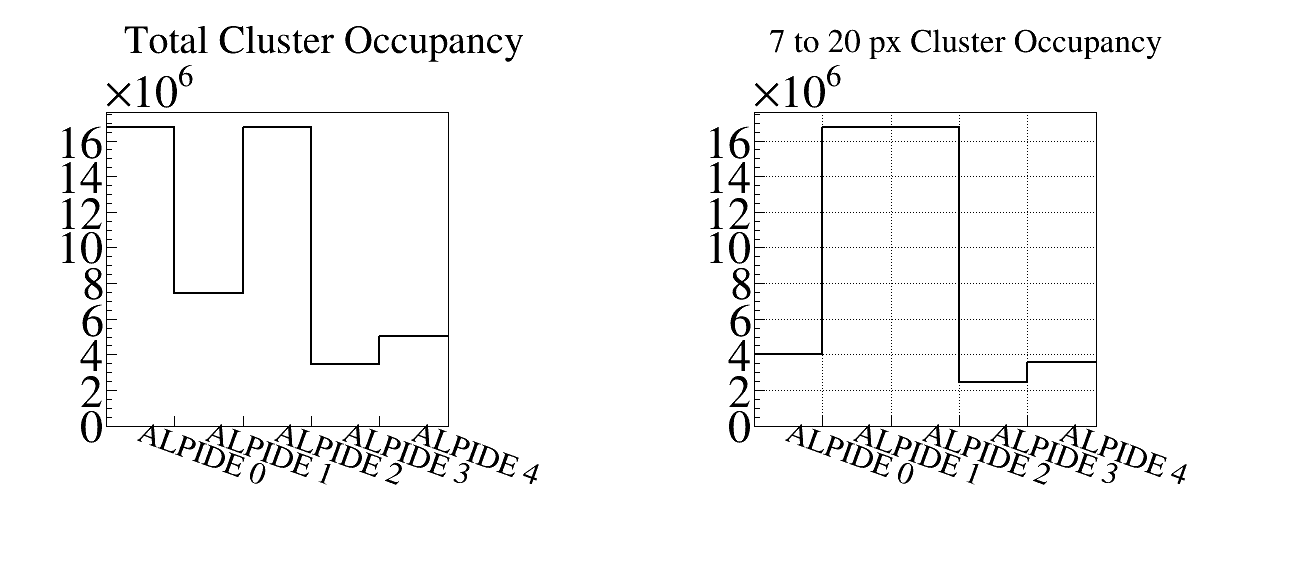

In [10]:
# %jsroot on
detectors = ["ALPIDE_0","ALPIDE_1","ALPIDE_2","ALPIDE_3","ALPIDE_4"]
canvas = ROOT.TCanvas("","",1300,600)
canvas.Divide(2,1)
legend = ROOT.TLegend()

# Calculate histogram
hClusSize = ROOT.TH1F("ALPIDE_occupancy", "Total Cluster Occupancy", 5, -0.5, 4.5)
hClusSize1 = ROOT.TH1F("ALPIDE_occupancy", "7 to 20 px Cluster Occupancy", 5, -0.5, 4.5)
for event in readEvents("/home/cehrich/Software/uits3_krakow22/pickleNeedsFlip/run456195948_221112200957.pkl" ,-1):
    for cluster in event.clusters:
        hClusSize.Fill(cluster.detector,1)
        if 20 > cluster.size > 7:
            hClusSize1.Fill(cluster.detector,1)

# Set bin labels
for i, det in enumerate(detectors):
    hClusSize.GetXaxis().SetBinLabel(i+1, det.replace('_', ' '))
    hClusSize1.GetXaxis().SetBinLabel(i+1, det.replace('_', ' '))

#Draw histogram
canvas.cd(1)
ROOT.gPad.SetGrid(2)
hClusSize.SetLineWidth(2)
hClusSize.SetLineColor(ROOT.kBlack)
hClusSize.SetMinimum(0)
hClusSize.Draw("SAME HIST")
canvas.cd(2)
ROOT.gPad.SetGrid(2)
hClusSize1.SetLineWidth(2)
hClusSize1.SetLineColor(ROOT.kBlack)
hClusSize1.SetMinimum(0)
hClusSize1.Draw("SAME HIST")

ROOT.gStyle.SetPadLeftMargin(0.15)
ROOT.gStyle.SetPadRightMargin(0.3)
ROOT.gStyle.SetPadBottomMargin(0.25)
ROOT.gStyle.SetPadTopMargin(0.19)
canvas.Draw()

canvas.SaveAs("cluster_occupancy_plots.pdf")

Info in <TCanvas::Print>: pdf file cluster_occupancy_plots.pdf has been created


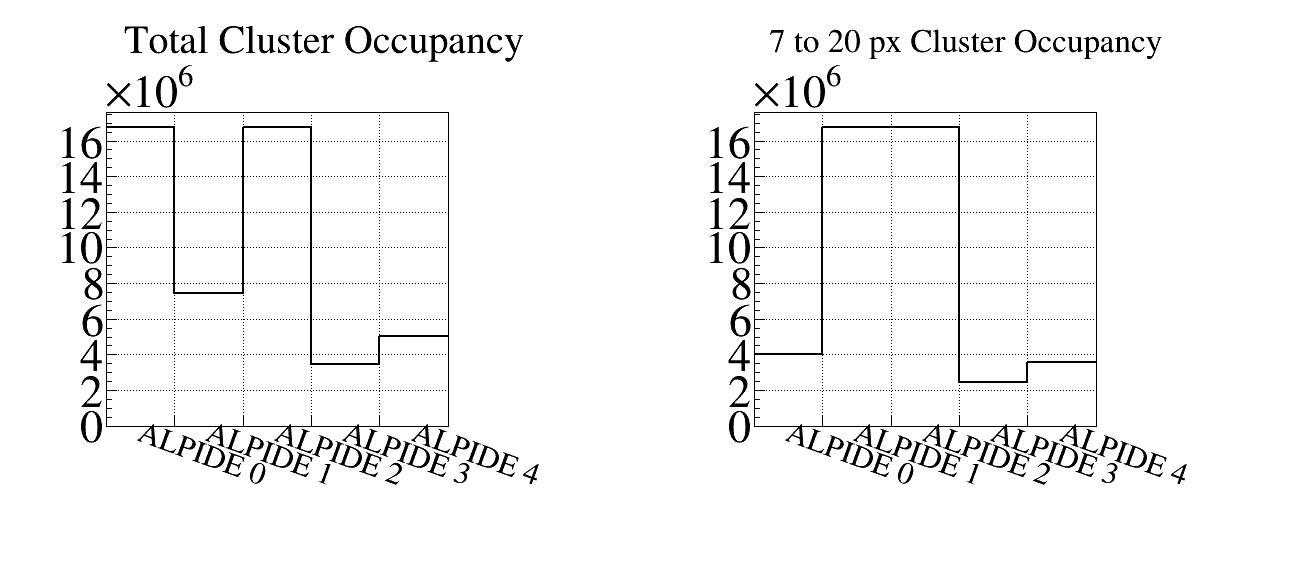

In [11]:
#Draw histogram
canvas.cd(1)
ROOT.gPad.SetGrid(2)
hClusSize.SetLineWidth(2)
hClusSize.SetLineColor(ROOT.kBlack)
hClusSize.SetMinimum(0)
hClusSize.Draw("SAME HIST")
canvas.cd(2)
ROOT.gPad.SetGrid(2)
hClusSize1.SetLineWidth(2)
hClusSize1.SetLineColor(ROOT.kBlack)
hClusSize1.SetMinimum(0)
hClusSize1.Draw("SAME HIST")

ROOT.gStyle.SetPadLeftMargin(0.15)
ROOT.gStyle.SetPadRightMargin(0.3)
ROOT.gStyle.SetPadBottomMargin(0.25)
ROOT.gStyle.SetPadTopMargin(0.19)
canvas.Draw()

canvas.SaveAs("cluster_occupancy_plots.pdf")

In [153]:
%jsroot on
canvas = ROOT.TCanvas()
canvas.SetCanvasSize(900,600)

# Calculate histogram
h2DClusSizeVsColWidth = [ROOT.TH2F("Cluster_Size_vs_ColWidth"+det, "Size of cluster vs column width- "+det, 30,0,30,10,0,10) for det in detectors]
for event in events:
    for index,detector in enumerate(detectors):
        for cluster in event.clusters:
            if cluster.detector == detector:
                h2DClusSizeVsColWidth[index].Fill(cluster.size,cluster.colWidth)

#Draw histogram
canvas.Divide(3,2)
for pad ,index in enumerate([0,1,2,5,3]):

    canvas.cd(index+1)
    h2DClusSizeVsColWidth[pad].GetZaxis().SetLabelSize(0.09)
    h2DClusSizeVsColWidth[pad].Draw("COLZ")
    h2DClusSizeVsColWidth[pad].SetTitle("ALPIDE "+str(pad)+"; Cluster Size [px]; Column Width [px]")
    #palette = hist.GetListOfFunctions().FindObject("palette")    legend.SetX1NDC(0.7)
    legend.SetY1NDC(0.7)
    legend.SetX2NDC(0.9)
    legend.SetY2NDC(0.9)
canvas.Update()    
canvas.Draw()
canvas.SaveAs("cluster_size_vs_col_width.pdf")

Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_vs_ColWidthALPIDE_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_vs_ColWidthALPIDE_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_vs_ColWidthALPIDE_2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_vs_ColWidthALPIDE_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cluster_Size_vs_ColWidthALPIDE_4 (Potential memory leak).
Info in <TCanvas::Print>: pdf file cluster_size_vs_col_width.pdf has been created


### Number of clusters

In [7]:
%jsroot on
canvas = ROOT.TCanvas()
canvas.SetCanvasSize(900,900)
canvas.Divide(2,2)
cuts = {0:0,
        1:5,
        2:10,
        3:15
       }
hNClusDet = []
for pad in range(4):
    # Fill histograms
    hNClusDet.append([ROOT.TH1F("nClusters_"+det+"_cut_"+str(pad), "nClusters of events - "+det, 30, 0, 30) for det in detectors])
    for event in events:
        for index,detector in enumerate(detectors):
            count = 0
            for cluster in event.clusters:
                if cluster.detector == detector and cluster.size > cuts.get(pad):
                    count += 1
            if count:
                hNClusDet[pad][index].Fill(count)
                
    # Draw histograms
    canvas.cd(pad+1)
    legend = ROOT.TLegend()
    #hNClus.Draw()
    for index,hist in enumerate(hNClusDet[pad]):
        hist.Scale(1/hist.Integral())
        #hist.SetMaximum(0.15)
        hist.SetLineColor(colors[index])
        hist.SetLineWidth(2)
        hist.SetXTitle("Clusters per Event")
        hist.SetYTitle("Normalized Counts")
        hist.SetTitle("Cluster Size > "+str(cuts.get(pad)))
        legend.AddEntry(hist,detectors[index])
        hist.Draw("SAME HIST")
    legend.Draw()
canvas.Draw()

UsageError: Line magic function `%jsroot` not found.


### Correlation plots
+ To-Do make sure this is the right way to do it

In [8]:
nBins = {"x-Axis" : 500, "y-Axis" : 250} #half the bins on this is fine i think
nRange = {"x-Axis" : 15, "y-Axis" : 7}
axis = {"x-Axis":0, "y-Axis":1}

In [3]:
%jsroot on
canvas = ROOT.TCanvas()
legend = ROOT.TLegend()

detector1 = "ALPIDE_2"
detector2 = "ALPIDE_2"
detector3 = "ALPIDE_3"
detector4 = "ALPIDE_3"
axis1="x-Axis"
axis2="y-Axis"
minclustsize = 2
# Calculate histogram
# hCorr1 = ROOT.TH2F("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2,"Correlation", nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
# hCorr1.SetXTitle("ALPIDE "+detector1[-1] + " - " + axis1)
# hCorr1.SetYTitle("ALPIDE "+detector2[-1] + " - " + axis2)

# hCorr2 = ROOT.TH2F("Corr_"+detector3+"_"+axis1+"_"+detector4+"_"+axis2,"Correlation", nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
# hCorr2.SetXTitle("ALPIDE "+detector3[-1] + " - " + axis1)
# hCorr2.SetYTitle("ALPIDE "+detector4[-1] + " - " + axis2)
#different labeling
hCorr1 = ROOT.TH2F("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2,"ALPIDE "+detector1[-1] , nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
hCorr1.SetXTitle(axis1+ " [mm]")
hCorr1.SetYTitle(axis2+ " [mm]")

hCorr2 = ROOT.TH2F("Corr_"+detector3+"_"+axis1+"_"+detector4+"_"+axis2,"ALPIDE "+detector3[-1] , nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
hCorr2.SetXTitle(axis1+ " [mm]")
hCorr2.SetYTitle(axis2+ " [mm]")

#for event in events:
reps = -1 #1e7
for i, event in enumerate(readEvents('/home/cehrich/Software/uits3_krakow22/noFlipNeeded/run447162516_221106162754.pkl',reps)):
    if i % 50 == 0:
        percentage_done = (i / reps) * 100
    # Print the percentage completion
        print(f"Progress: {percentage_done:.2f}% done", end='\r')
    
    clustersDetector1 = event.selectDetector(detector1)
    clustersDetector2 = event.selectDetector(detector2)
    clustersDetector3 = event.selectDetector(detector3)
    clustersDetector4 = event.selectDetector(detector4)
    #if len(clustersDetector1) == 1 and len(clustersDetector2) == 1:
    if True:
        for cluster1 in clustersDetector1:
            if cluster1.size > minclustsize:
                for cluster2 in clustersDetector2:
                    if cluster2.size > minclustsize:
                        hCorr1.Fill(cluster1.localPos[axis.get(axis1)],cluster2.localPos[axis.get(axis2)])
        for cluster3 in clustersDetector3:
            if cluster3.size > minclustsize:
                for cluster4 in clustersDetector4:
                    if cluster4.size > minclustsize:
                        hCorr2.Fill(cluster3.localPos[axis.get(axis1)],cluster4.localPos[axis.get(axis2)])


UsageError: Line magic function `%jsroot` not found.


In [4]:
%jsroot on
for hCorr in [hCorr1,hCorr2]:
    #hCorr.SetMaximum(1/hCorr.Integral())
    # hCorr.SetMaximum(10)
    #hCorr.SetMaximum(hCorr.Integral()/100000005)
    #hCorr.SetMinimum(-1)
    hCorr.GetZaxis().SetLabelFont(132)
    hCorr.GetZaxis().SetLabelSize(0.09)  # Increase Z-axis label font size
    hCorr.Rebin2D(2,2)
canvas = ROOT.TCanvas("", "", 1200, 280) #60 x 14, 14x40= 560, 30x40=1200
#canvas = ROOT.TCanvas("", "", 600, 280)
ROOT.gStyle.SetPadLeftMargin(0.2)
ROOT.gStyle.SetPadRightMargin(0.2)#should also be 1.1 rather than 1.0 to not cut off the axis label brackets
ROOT.gStyle.SetPadBottomMargin(0.21)
ROOT.gStyle.SetPaintTextFormat(".1f")

canvas.Update()

canvas.Divide(2,1)
canvas.cd(1)
hCorr1.GetYaxis().SetRangeUser(-7, 7) 
hCorr1.Draw("COLZ")

canvas.cd(2)
hCorr2.GetYaxis().SetRangeUser(-7, 7) 
hCorr2.Draw("COLZ")

canvas.Draw()
#canvas.SaveAs("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2+".pdf")
canvas.SaveAs("inner_ALPIDE_HitMap1_rebin.pdf")

UsageError: Line magic function `%jsroot` not found.


In [5]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [6]:
save_object(events,"myEvents.pkl")

NameError: name 'events' is not defined

In [ ]:
# Dictionaries for axes
nBins = {"x-Axis" : 120, "y-Axis" : 60}
nRange = {"x-Axis" : 15, "y-Axis" : 7.5}
axis = {"x-Axis":0, "y-Axis":1}

In [ ]:
def correlationHist(detector1="ALPIDE_1", detector2="ALPIDE_1", axis1="x-Axis", axis2="x-Axis"):
    global nBins,nRange,axName
    hCorr = ROOT.TH2F("Corr"+detector1+axis1+detector2+axis2,"Correlation", nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
    hCorr.SetXTitle(detector1 + " - " + axis1)
    hCorr.SetYTitle(detector2 + " - " + axis2)
    for event in events:
        clustersDetector1 = event.selectDetector(detector1)
        clustersDetector2 = event.selectDetector(detector2)
        for cluster1 in clustersDetector1:
            if cluster1.size > 15:
                for cluster2 in clustersDetector2:
                    if cluster2.size > 15:
                        hCorr.Fill(cluster1.localPos[axis.get(axis1)],cluster2.localPos[axis.get(axis2)])
    return hCorr

In [ ]:
%jsroot on
axis1="x-Axis"
axis2="x-Axis"
canvas = ROOT.TCanvas()
hist = correlationHist(detector1="ALPIDE_1", detector2="ALPIDE_1", axis1="x-Axis", axis2="x-Axis")
hist.Draw("COLZ")
canvas.Draw()


In [ ]:
%jsroot on
canvas = ROOT.TCanvas()
legend = ROOT.TLegend()

# Calculate histogram
hMyHist = ROOT.TH1F("myHist", "myHist", 30, 0, 30)
for event in events:
    for cluster in event.clusters:
        if int(cluster.detector[-1]) == 1 :
            hMyHist.Fill(cluster.size)

#Draw histogram
hMyHist.Draw()

#legend.Draw() 
canvas.Draw()